In [189]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/a-t-w/train.csv
/kaggle/input/a-t-w/test.csv


In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
import random
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import pickle
import joblib


# helper functions

In [191]:
# Function to drop specified columns
def drop_columns(data, columns):
    data.drop(columns, axis='columns', inplace=True)

In [192]:
# Function to replace specific characters 
def replace_values(data, column_name, replace_dict, regex=True):
    for old_value, new_value in replace_dict.items():
        data[column_name] = data[column_name].replace(old_value, new_value, regex=regex)
    return data


In [193]:
# Function to fill missing values based on Customer_ID coulmn
def fill_missing(data, column_name, fill_method, group_column="Customer_ID"):
    if fill_method == 'mode':
        data[column_name] = data.groupby(group_column)[column_name].transform(lambda x: x.fillna(x.mode()[0]))
    elif fill_method == 'median':
        data[column_name] = data.groupby(group_column)[column_name].transform(lambda x: x.fillna(x.median()))
    elif fill_method == 'mean':
        data[column_name] = data.groupby(group_column)[column_name].transform(lambda x: x.fillna(x.mean()))
    return data

# load dataset

In [194]:
data=pd.read_csv("/kaggle/input/a-t-w/train.csv")
data

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.866228,Poor
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.65161,Poor
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.809083,Poor
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.164979,Standard


In [195]:
test_data=pd.read_csv("/kaggle/input/a-t-w/test.csv")
test_data.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


# data exploration 

In [196]:
test_data.shape

(50000, 27)

In [197]:
test_data.isna().sum()

ID                             0
Customer_ID                    0
Month                          0
Name                        5015
Age                            0
SSN                            0
Occupation                     0
Annual_Income                  0
Monthly_Inhand_Salary       7498
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                5704
Delay_from_due_date            0
Num_of_Delayed_Payment      3498
Changed_Credit_Limit           0
Num_Credit_Inquiries        1035
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age          4470
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly     2271
Payment_Behaviour              0
Monthly_Balance              562
dtype: int64

In [198]:
data.shape

(100000, 28)

In [199]:
data.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


In [200]:
data.nunique()

ID                          100000
Customer_ID                  12500
Month                            8
Name                         10139
Age                           1788
SSN                          12501
Occupation                      16
Annual_Income                18940
Monthly_Inhand_Salary        13235
Num_Bank_Accounts              943
Num_Credit_Card               1179
Interest_Rate                 1750
Num_of_Loan                    434
Type_of_Loan                  6260
Delay_from_due_date             73
Num_of_Delayed_Payment         749
Changed_Credit_Limit          4384
Num_Credit_Inquiries          1223
Credit_Mix                       4
Outstanding_Debt             13178
Credit_Utilization_Ratio    100000
Credit_History_Age             404
Payment_of_Min_Amount            3
Total_EMI_per_month          14950
Amount_invested_monthly      91049
Payment_Behaviour                7
Monthly_Balance              98792
Credit_Score                     3
dtype: int64

In [201]:
data.isnull().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

In [202]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [203]:
data.duplicated().sum()

0

## delete unnessesary and unique identifiers columns 

In [204]:
#delete unnessesary and unique identifiers columns 
columns_to_drop = ['Name', 'SSN', 'ID', 'Num_Credit_Inquiries']

# Drop specified columns from 'data', 'test_data'
drop_columns(data, columns_to_drop)
# drop_columns(test_data, columns_to_drop)

# data cleaning 

### handel missing values ###

In [205]:
data.isna().sum()

Customer_ID                     0
Month                           0
Age                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

In [206]:
data.Month.unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

## clean & process age column 
* replace _,-, (any value >100) with nan
* fill nan with the median of same customer_id 
* convert age to int 
* group the age into 'Young', 'Middle_Aged', 'Senior' 

In [207]:
data.Age.unique()

array(['23', '-500', '28_', ..., '4808_', '2263', '1342'], dtype=object)

In [208]:
# replace _,- with ""
data = replace_values(data, "Age", {"-": "", "_": ""})

#convert age to int
data["Age"] = pd.to_numeric(data["Age"],downcast='integer', errors="coerce")

In [209]:
print(min(data["Age"]))
print(max(data["Age"]))

14
8698


In [210]:
#replace anyval of age >100 with ""
data["Age"] = data["Age"].apply(lambda x: " " if x > 100 else x)

#replace "" with nan
data["Age"] = data["Age"].replace(" ", np.nan)

#Convert Age column to numeric
data["Age"] = pd.to_numeric(data["Age"], errors="coerce")

# fill nan with median of each customer id
data = fill_missing(data, "Age", 'median')

# group the age into 'Young', 'Middle_Aged', 'Senior'
data['Age'] = pd.cut(data['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle_Aged', 'Senior'])


In [211]:
data.Age.unique()

['Young', 'Middle_Aged', 'Senior']
Categories (3, object): ['Young' < 'Middle_Aged' < 'Senior']

## clean & process Occupation column
* replace _______ with nan
* fill nan with the mode of each customer_id
* replace any other nan to unemployed



In [212]:
data = replace_values(data, "Occupation", {"_______": ""})
data = fill_missing(data, "Occupation", 'mode')
data = replace_values(data, "Occupation", {"": "unemployed"})

In [213]:
data["Occupation"].unique()

array(['Scientist', 'unemployed', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

In [214]:
# replace _______ with ""
data = replace_values(data, "Occupation", {"_______": ""})

#fill na with mode of Occupation of same customer
data = fill_missing(data, "Occupation", 'mode')

In [215]:
data["Occupation"].unique()

array(['Scientist', 'unemployed', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

In [216]:
# replace nan to unemployed
data = replace_values(data, "Occupation", {"": "unemployed"})

## clean & process Annual_Income column
* replace _______ with nan
* convert datatype to float
* group Annual_Income into 'Low', 'Medium', 'High'


In [217]:
data["Annual_Income"].unique()

array(['19114.12', '34847.84', '34847.84_', ..., '20002.88', '39628.99',
       '39628.99_'], dtype=object)

In [218]:
# replace _ with ""
data = replace_values(data, "Annual_Income", {"_": ""})

# convert the data type to float
data["Annual_Income"] = pd.to_numeric(data["Annual_Income"], errors="coerce") 

In [219]:
# group Annual_Income into 'Low', 'Medium', 'High'
data['Annual_Income_Category'] = pd.cut(data['Annual_Income'], bins=[0, 50000, 100000, np.inf], labels=['Low', 'Medium', 'High'])

## clean & process Monthly_Inhand_Salary column
* fill nan with median of each customer id


In [220]:
#fill na with median Monthly_Inhand_Salary of same customer
data["Monthly_Inhand_Salary"] = data.groupby("Customer_ID")["Monthly_Inhand_Salary"].transform(
    lambda x: x.fillna(x.median()))

In [221]:
data["Num_Bank_Accounts"].unique()

array([   3,    2,    1,    7,    4,    0,    8,    5,    6,    9,   10,
       1414, 1231,   67,  572, 1488,   91,  528, 1647, 1696, 1338,  649,
        889, 1668,  685,  857,  975, 1496, 1534, 1620,   37, 1388, 1429,
       1332, 1588,  120, 1777, 1096,  803,  494,  744, 1139,  831, 1613,
        741,  121,  665, 1748, 1644,  823, 1356, 1651,   87,  711,  450,
        210, 1671, 1722,  648,  672, 1662, 1495,  510,  666,  429, 1131,
       1434,  980, 1026,  526,  718, 1300, 1312, 1315,  501, 1566,  480,
       1042,  322,  628, 1016,  333, 1265,  791,  427,  563,  905, 1190,
       1036, 1611,   38,  619,  555, 1769,  280,  752, 1201,  812, 1487,
        222,  212, 1019, 1222,  610, 1714, 1308,  525, 1158, 1115, 1616,
        754, 1601,  797, 1577,  521,  703,  933,  959,  809, 1089, 1656,
       1113, 1715,  964, 1533, 1789,  871,  434, 1295,  565, 1724,  603,
        677,  541,  698, 1101,  464, 1539, 1462, 1011, 1257, 1727,   45,
        244, 1266,  897,  535,  484,  331,  675,  8

In [222]:
data.Num_Credit_Card.unique()

array([   4, 1385,    5, ...,  955, 1430,  679])

In [223]:
data["Interest_Rate"].unique()

array([   3,    6,    8, ..., 1347,  387, 5729])

## clean & process Num_of_Loan column
* replace -,_,-100 with nan ,0


In [224]:
data.Num_of_Loan.unique()

array(['4', '1', '3', '967', '-100', '0', '0_', '2', '3_', '2_', '7', '5',
       '5_', '6', '8', '8_', '9', '9_', '4_', '7_', '1_', '1464', '6_',
       '622', '352', '472', '1017', '945', '146', '563', '341', '444',
       '720', '1485', '49', '737', '1106', '466', '728', '313', '843',
       '597_', '617', '119', '663', '640', '92_', '1019', '501', '1302',
       '39', '716', '848', '931', '1214', '186', '424', '1001', '1110',
       '1152', '457', '1433', '1187', '52', '1480', '1047', '1035',
       '1347_', '33', '193', '699', '329', '1451', '484', '132', '649',
       '995', '545', '684', '1135', '1094', '1204', '654', '58', '348',
       '614', '1363', '323', '1406', '1348', '430', '153', '1461', '905',
       '1312', '1424', '1154', '95', '1353', '1228', '819', '1006', '795',
       '359', '1209', '590', '696', '1185_', '1465', '911', '1181', '70',
       '816', '1369', '143', '1416', '455', '55', '1096', '1474', '420',
       '1131', '904', '89', '1259', '527', '1241', '449', 

In [225]:
#replace -,_,-100 with nan ,0
data = replace_values(data, "Num_of_Loan", {"-100": "0","-": "", "_": ""})

#convert to int
data["Num_of_Loan"] = pd.to_numeric(data["Num_of_Loan"],downcast='integer', errors="coerce")

## clean & process Type_of_Loan column
* if the value is nan set "Not Specified"
* if the value has , set "other" (the loan should be taken for one reason)
* if the value is single value return it

In [226]:
data.Type_of_Loan.unique()

array(['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan',
       'Credit-Builder Loan', 'Auto Loan, Auto Loan, and Not Specified',
       ..., 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan',
       'Payday Loan, Student Loan, Mortgage Loan, and Not Specified',
       'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan'],
      dtype=object)

In [227]:
data.Type_of_Loan.value_counts()

Type_of_Loan
Not Specified                                                                                                                         1408
Credit-Builder Loan                                                                                                                   1280
Personal Loan                                                                                                                         1272
Debt Consolidation Loan                                                                                                               1264
Student Loan                                                                                                                          1240
                                                                                                                                      ... 
Not Specified, Mortgage Loan, Auto Loan, and Payday Loan                                                                                 8
Payday Loan, M

In [228]:
def process_cell(value):
    # if nan set "Not Specified"
    if pd.isna(value):  
        return "Not Specified"
    # if it has , return other  
    elif "," in value:  
        return "Other"
    # if it single value return it
    else:
        return value.strip()  

data["Type_of_Loan"] = data["Type_of_Loan"].apply(process_cell)

## clean & process Num_of_Delayed_Payment column
* replace _ with nan
* convert data type to number
* fill nan with median for each customer_id

In [229]:
data.Num_of_Delayed_Payment.unique()

array(['7', nan, '4', '8_', '6', '1', '-1', '3_', '0', '8', '5', '3', '9',
       '12', '15', '17', '10', '2', '2_', '11', '14', '20', '22', '13',
       '13_', '14_', '16', '12_', '18', '19', '23', '24', '21', '3318',
       '3083', '22_', '1338', '4_', '26', '11_', '3104', '21_', '25',
       '10_', '183_', '9_', '1106', '834', '19_', '24_', '17_', '23_',
       '2672', '20_', '2008', '-3', '538', '6_', '1_', '16_', '27', '-2',
       '3478', '2420', '15_', '707', '708', '26_', '18_', '3815', '28',
       '5_', '1867', '2250', '1463', '25_', '7_', '4126', '2882', '1941',
       '2655', '2628', '132', '3069', '306', '0_', '3539', '3684', '1823',
       '4128', '1946', '827', '2297', '2566', '904', '182', '929', '3568',
       '2503', '1552', '2812', '1697', '3764', '851', '3905', '923', '88',
       '1668', '3253', '808', '2689', '3858', '642', '3457', '1402',
       '1732', '3154', '847', '3037', '2204', '3103', '1063', '2056',
       '1282', '1841', '2569_', '211', '793', '3484', '4

In [230]:
# replace _ with ""
data = replace_values(data, "Num_of_Delayed_Payment", {"_": ""})

#convert data type to number
data["Num_of_Delayed_Payment"] = pd.to_numeric(data["Num_of_Delayed_Payment"], errors="coerce")

# fill nan with median for each customer_id
data = fill_missing(data, "Num_of_Delayed_Payment", 'median')


## clean & process Changed_Credit_Limit column
* replace _ with ""
* convert data type to float
* fill nan with median for each customer_id

In [231]:
data.Changed_Credit_Limit.unique()

array(['11.27', '_', '6.27', ..., '17.509999999999998', '25.16', '21.17'],
      dtype=object)

In [232]:
# replace _ with ""
data = replace_values(data, "Changed_Credit_Limit", {"_": ""})

#convert data type to float
data["Changed_Credit_Limit"] = pd.to_numeric(data["Changed_Credit_Limit"], errors="coerce")

# fill nan with median for each customer_id
data = fill_missing(data, "Changed_Credit_Limit", 'median')

## clean & process Credit_Mix column
* replace _ with nan
* fill nan with mode for each customer_id

In [233]:
data.Credit_Mix.unique()

array(['_', 'Good', 'Standard', 'Bad'], dtype=object)

In [234]:
#replace _ with nan
data = replace_values(data, "Credit_Mix", {"_": np.nan})

# fill nan with mode for each customer_id
data = fill_missing(data, "Credit_Mix", 'mode')

In [235]:
data.Credit_Mix.value_counts()

Credit_Mix
Standard    45848
Good        30384
Bad         23768
Name: count, dtype: int64

## clean & process Outstanding_Debt column
* replace _ with ""
* convert data type to float

In [236]:
data.Outstanding_Debt.value_counts()

Outstanding_Debt
1360.45     24
460.46      23
1151.7      23
1109.03     23
467.7       16
            ..
245.46_      1
645.77_      1
174.79_      1
1181.13_     1
1013.53_     1
Name: count, Length: 13178, dtype: int64

In [237]:
#replace _ with ""
data = replace_values(data, "Outstanding_Debt", {"_": ""})

#convert data type to float
data["Outstanding_Debt"] = pd.to_numeric(data["Outstanding_Debt"], errors="coerce")

In [238]:
data.Credit_Utilization_Ratio.unique()

array([26.82261962, 31.94496006, 28.60935202, ..., 41.25552226,
       33.63820798, 34.19246265])

## clean & process Credit_History_Age column
* fill missing Credit_History_Age with mode of each customer_id
* convert the years and months to total months using regex
  (total months is easier to the model to learn unlike the original values years and months )


In [239]:
#fill missing Credit_History_Age with mode of each customer_id
data = fill_missing(data, "Credit_History_Age", 'mode')

In [240]:
data["Credit_History_Age"]

0         22 Years and 1 Months
1         22 Years and 1 Months
2         22 Years and 3 Months
3         22 Years and 4 Months
4         22 Years and 5 Months
                  ...          
99995     31 Years and 6 Months
99996     31 Years and 7 Months
99997     31 Years and 8 Months
99998     31 Years and 9 Months
99999    31 Years and 10 Months
Name: Credit_History_Age, Length: 100000, dtype: object

In [241]:
# convert the years and months to total months using regex
def convert_to_months(age_str):
    match = re.match(r"(\d+)\sYears\sand\s(\d+)\sMonths", age_str)
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years * 12 + months  

data["Credit_History_Age"] = data["Credit_History_Age"].apply(convert_to_months)

In [242]:
data["Credit_History_Age"]

0        265
1        265
2        267
3        268
4        269
        ... 
99995    378
99996    379
99997    380
99998    381
99999    382
Name: Credit_History_Age, Length: 100000, dtype: int64

## clean & process Payment_of_Min_Amount column
* replace NM with NO 


In [243]:
data.Payment_of_Min_Amount.unique()

array(['No', 'NM', 'Yes'], dtype=object)

In [244]:
data.Payment_of_Min_Amount.value_counts()

Payment_of_Min_Amount
Yes    52326
No     35667
NM     12007
Name: count, dtype: int64

In [245]:
#replace NM with NO 
data = replace_values(data, "Payment_of_Min_Amount", {"NM": "No"})

In [246]:
data.Payment_of_Min_Amount.value_counts()

Payment_of_Min_Amount
Yes    52326
No     47674
Name: count, dtype: int64

In [247]:
data.Total_EMI_per_month.unique()

array([4.95749492e+01, 1.88162146e+01, 2.46992319e+02, ...,
       1.21120000e+04, 3.51040226e+01, 5.86380000e+04])

## clean & process Amount_invested_monthly column

* replace __10000__ with "10000" 
* convert to float and round it to 3 digits (it has many digits which can be shortened to be easy)
* fill nan with mean of each customer_id

In [248]:
data.Amount_invested_monthly.unique()

array(['80.41529543900253', '118.28022162236736', '81.699521264648', ...,
       '24.02847744864441', '251.67258219721603', '167.1638651610451'],
      dtype=object)

In [249]:
#replace __10000__ with "10000" 
data = replace_values(data, "Amount_invested_monthly", {"__10000__": "10000"})

# convert to float and round it to 3 digits
data["Amount_invested_monthly"] = data["Amount_invested_monthly"].astype(float).round(3)

# fill na with mean of each customer_id
data = fill_missing(data, "Amount_invested_monthly", 'mean')

In [250]:
data.Amount_invested_monthly.unique()

array([ 80.415, 118.28 ,  81.7  , ...,  24.028, 251.673, 167.164])

## clean & process Payment_Behaviour column

* replace "!@9#%8" with nan
* fill nan with mode of each customer_id

In [251]:
data.Payment_Behaviour.unique()

array(['High_spent_Small_value_payments',
       'Low_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments', '!@9#%8',
       'High_spent_Large_value_payments'], dtype=object)

In [252]:
#replace "!@9#%8" with nan
data = replace_values(data, "Payment_Behaviour", {"!@9#%8": np.nan})

#fill nan with mode of each customer_id
data = fill_missing(data, "Payment_Behaviour", 'mode')

## clean & process Monthly_Balance column
* replace __ with ""
* convert to float and round it to 3 digit (it has many digits which can be shortened to be easy)
* fill nan with median of each customer_id

In [253]:
data.Monthly_Balance

0        312.49408867943663
1        284.62916249607184
2         331.2098628537912
3        223.45130972736786
4        341.48923103222177
                ...        
99995            479.866228
99996             496.65161
99997            516.809083
99998            319.164979
99999            393.673696
Name: Monthly_Balance, Length: 100000, dtype: object

In [254]:
#replace __ with ""
data = replace_values(data, "Monthly_Balance", {"__": ""})

# convert to float and round it to 3 digit
data["Monthly_Balance"] = data["Monthly_Balance"].astype(float).round(3)

#fill nan with median of each customer_id
data = fill_missing(data, "Monthly_Balance", 'median')

In [255]:
data.isna().sum()

Customer_ID                 0
Month                       0
Age                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
Annual_Income_Category      0
dtype: int64

In [256]:
len(data)

100000

In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   Customer_ID               100000 non-null  object  
 1   Month                     100000 non-null  object  
 2   Age                       100000 non-null  category
 3   Occupation                100000 non-null  object  
 4   Annual_Income             100000 non-null  float64 
 5   Monthly_Inhand_Salary     100000 non-null  float64 
 6   Num_Bank_Accounts         100000 non-null  int64   
 7   Num_Credit_Card           100000 non-null  int64   
 8   Interest_Rate             100000 non-null  int64   
 9   Num_of_Loan               100000 non-null  int16   
 10  Type_of_Loan              100000 non-null  object  
 11  Delay_from_due_date       100000 non-null  int64   
 12  Num_of_Delayed_Payment    100000 non-null  float64 
 13  Changed_Credit_Limit      1000

# data visualization

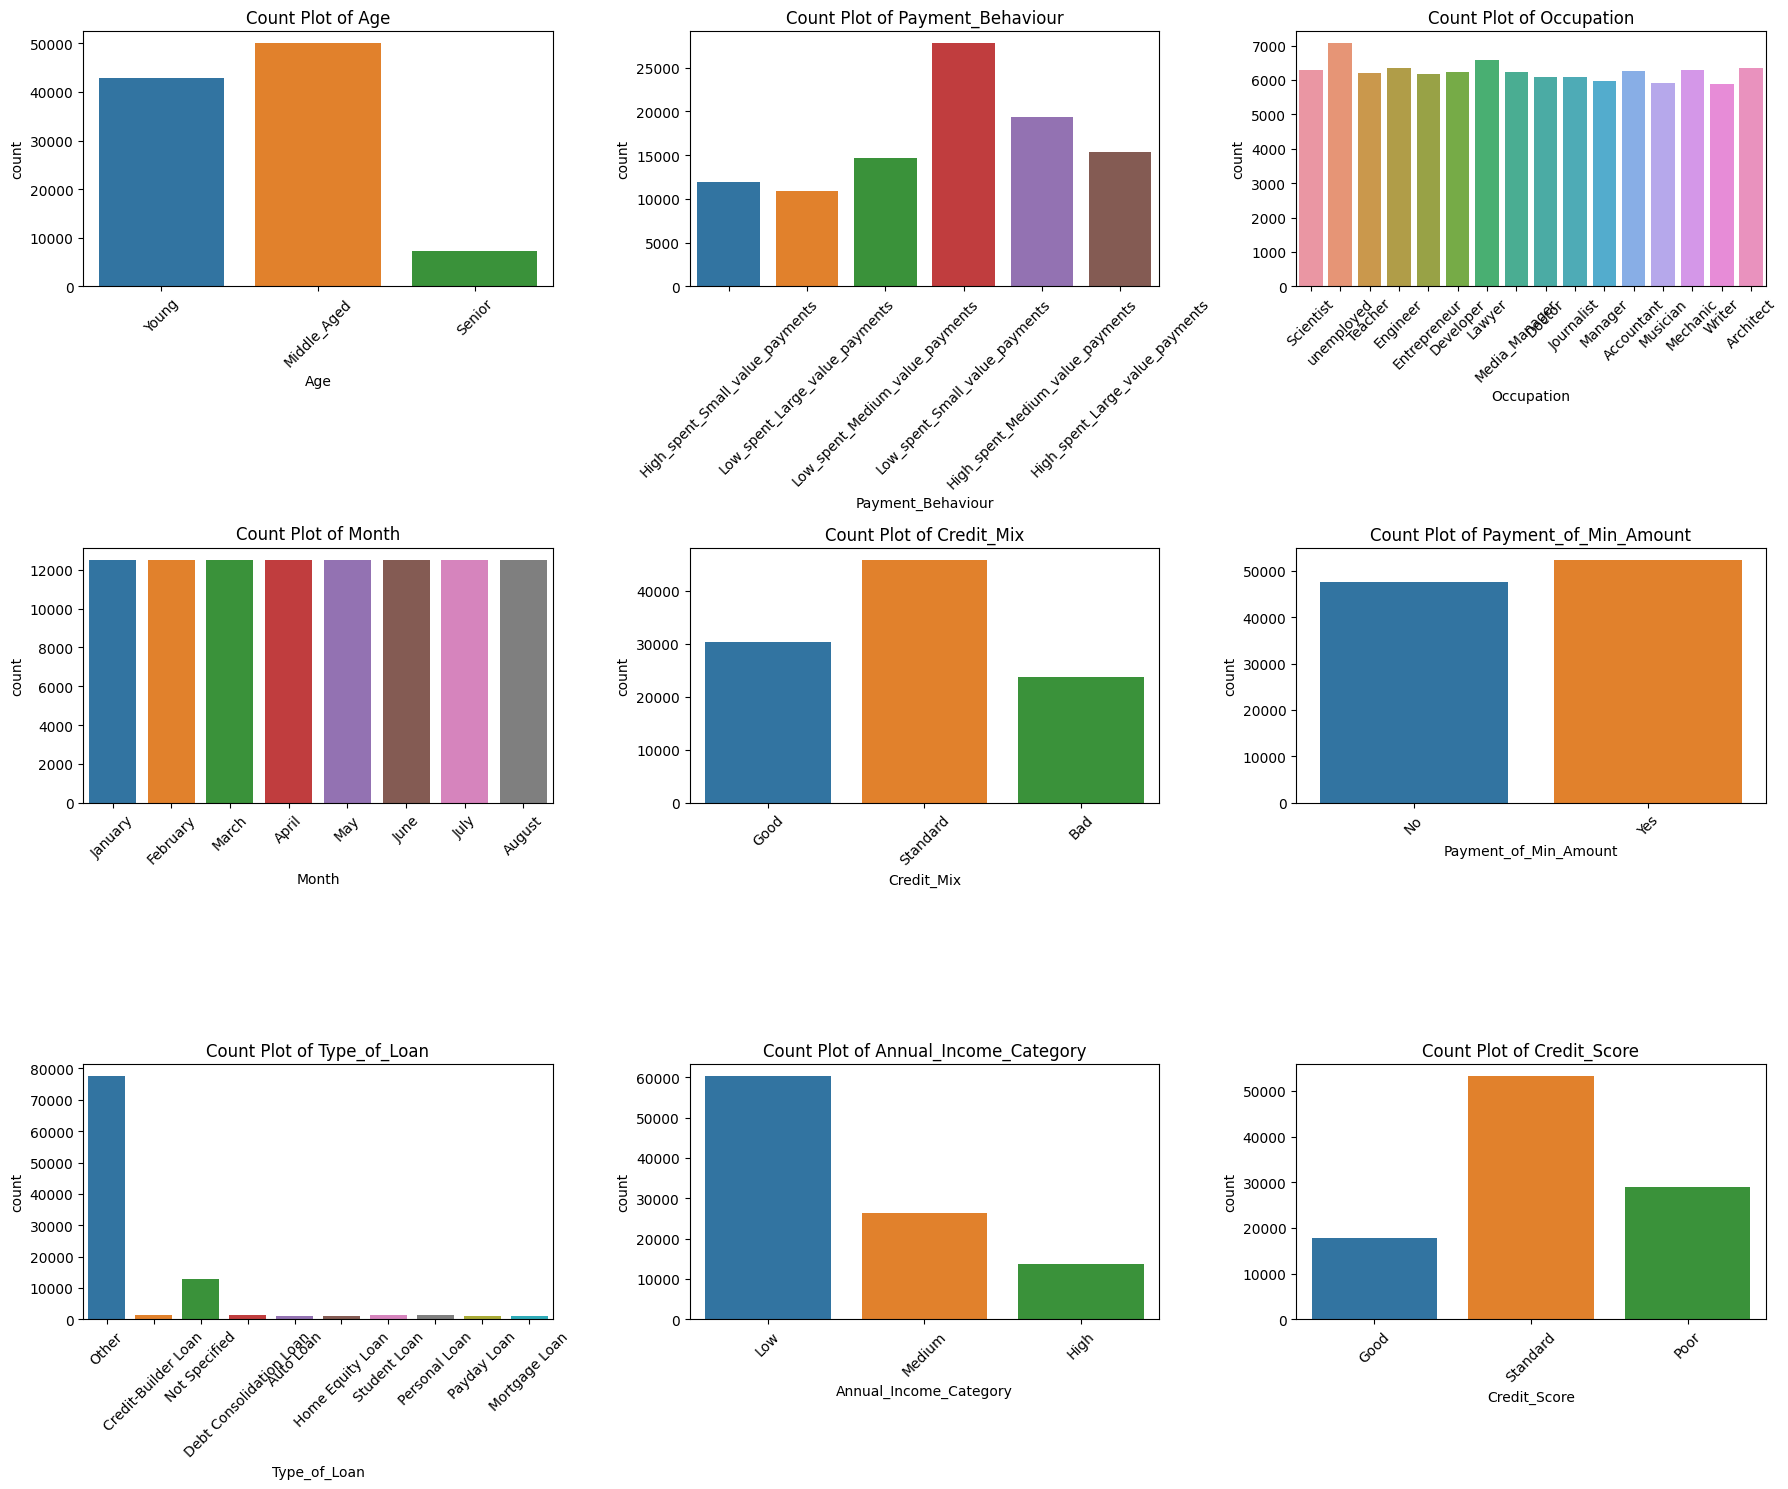

In [258]:
# List of categorical columns
categorical_columns = [ 'Age','Payment_Behaviour','Occupation','Month', 'Credit_Mix', 
                       'Payment_of_Min_Amount', 'Type_of_Loan','Annual_Income_Category','Credit_Score']

plt.figure(figsize=(18, 15))

# Plot each categorical column
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)  
    sns.countplot(data=data, x=col)
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


age distribution looks reasonable, as people <50 are of course more likely to apply for a loan than people >=50

while payment behavior isn't, as it is not expected that low_spent_small_value_payment is the most frequent between 25% of the costumers

occupation and month columns must be uniformly generated 

annaul income is somehow correlated with payment behaviour 

credit score and payment of min amount is not correlated which is wrong. as 'good' and 'standard' credit scores should be paying in time i.e. count(good + standards) is compared to count(payment of min amount)+ error


### outliar & distribution  handeling ###

In [259]:
numerical_columns = data.select_dtypes(include=['float64', 'int64','int16']).columns
numerical_columns

Index(['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance'],
      dtype='object')

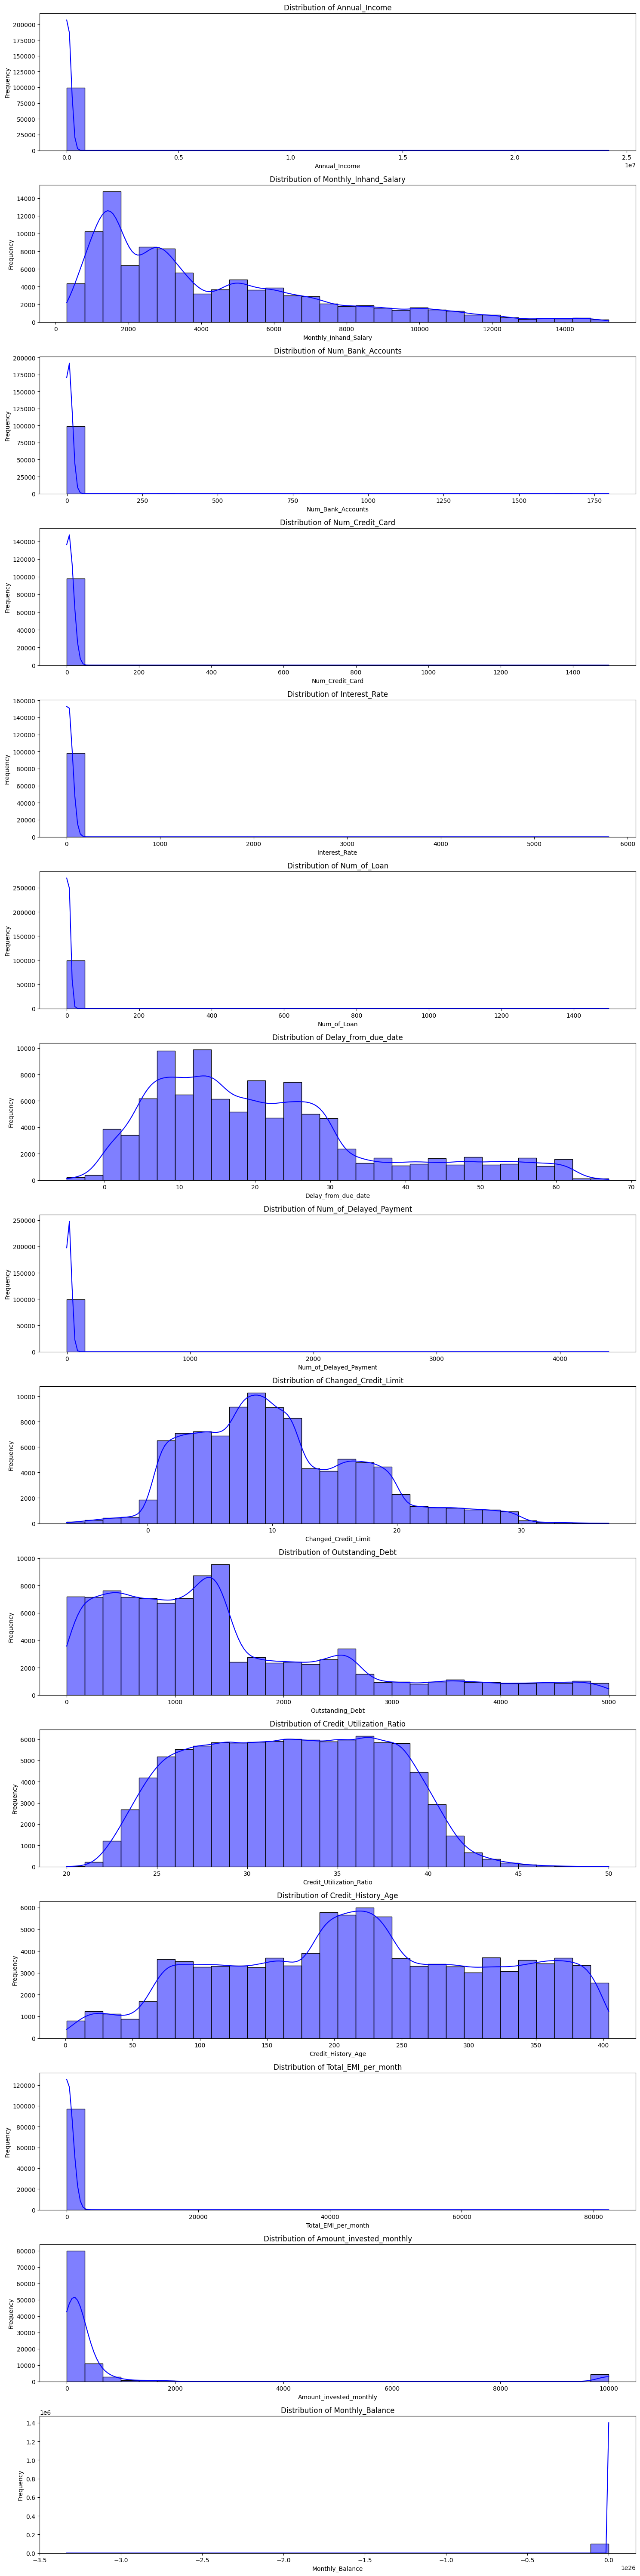

In [260]:
#draw the distribution of the data
numerical_columns = data.select_dtypes(include=['float64', 'int64', 'int16']).columns

# Plot each numerical column
plt.figure(figsize=(15, len(numerical_columns) * 4))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.histplot(data[col], kde=True, bins=30, color='blue') 
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

e']

* Num of Loans: The distribution appears highly skewed to the right, indicating that most loans have a low number of occurrences, with a few outliers extending the range.


* Outstanding Debt: the distribution highlights a common trend of lower outstanding debt among individuals, with fewer people experiencing higher levels of deit: 


* Credit Utilization Ratio: The distribution appears to be roughly bell-shaped, highlighting the common tendency among individuals to maintain a moderate credit utilization ratio

* TotIal EM per Month: The distribution is heavily skewed to the right, highlighting a significant disparity in totIal EM, with most individuals on the lower end and only a few achieving higher amounts

* Amount Invested Monthly: the data reflects a common pattern in investing behavior, where most individuals are cautious or limited in their monthly investment amounts, while a smaller group is willing to invest significantly more.

## remove outliers 
* 'Annual_Income' remove outliars using IQR 
* 'Monthly_Inhand_Salary' No changes needed because the monthly base salary of each person is differ based on their sociable level
* Clip 'Num_Bank_Accounts' to a maximum of 15 it should be realistic values
*  Clip 'Num_Credit_Card' to a maximum of 20 it should be realistic values
* 'Interest_Rate' remove outliers
* Clip 'Num_of_Loan' to a maximum of 150 it should be realistic values '
* Delay_from_due_date' No changes needed the distrubution is good and normal distributed
* Clip'Num_of_Delayed_Payment' to a maximum of 200 to 200  to remove all outliers
* Clip'Changed_Credit_Limit' to a maximum of 35 to remove all outliers
* 'Outstanding_Debt'  No changes needed because the column has no outliars
* 'Credit_Utilization_Ratio' No changes needed  its normaly distributed
* 'Credit_History_Age' No changes needed because the column has no outliars Remove outliers from
* 'Total_EMI_per_month' using the IQR method
* 'Amount_invested_monthly' No changes needed it depend on each person's income
* Clip all negative values in'Monthly_Balance' to start from 0 .-ve values are not realistic


In [261]:
# Function to remove outliers using the IQR method
def remove_outliers_iqr(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Function to clip values within a specified range
def clip_values(data, column, lower_bound=None, upper_bound=None):
    data[column] = np.clip(data[column], lower_bound, upper_bound)

# Preprocessing function for both datasets
def preprocess_data(data):
    # Remove outliers
    data = remove_outliers_iqr(data, 'Annual_Income')
    data = remove_outliers_iqr(data, 'Interest_Rate')
    data = remove_outliers_iqr(data, 'Total_EMI_per_month')
    
    # Clip values
    clip_values(data, 'Num_Bank_Accounts', None, 15)
    clip_values(data, 'Num_Credit_Card', None, 20)
    clip_values(data, 'Num_of_Loan', None, 150)
    clip_values(data, 'Num_of_Delayed_Payment', None, 200)
    clip_values(data, 'Changed_Credit_Limit', None, 35)
    clip_values(data, 'Monthly_Balance', 0, None) 
    
    return data

data = preprocess_data(data)

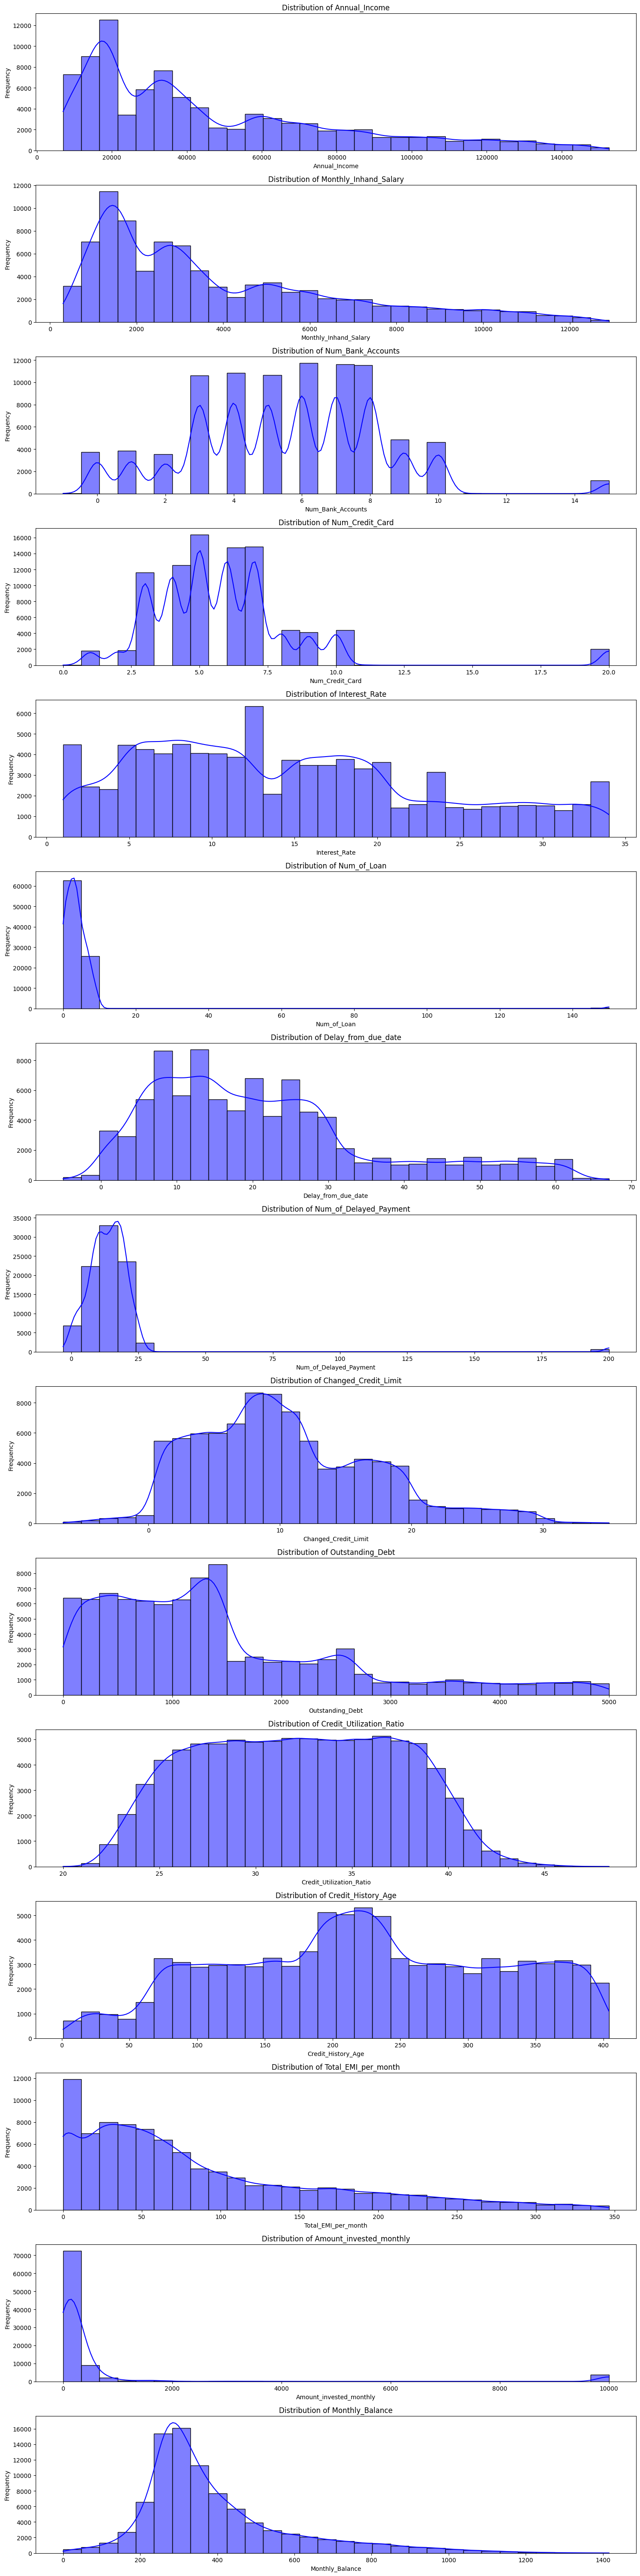

In [262]:
#draw the distribution of the data
numerical_columns = data.select_dtypes(include=['float64', 'int64', 'int16']).columns

# Plot each numerical column
plt.figure(figsize=(15, len(numerical_columns) * 4))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.histplot(data[col], kde=True, bins=30, color='blue') 
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Interest Rate: After removing outliers, the distribution appears less skewed, providing a more realistic range of loan rates. Rates that were excessively high (e.g., above 1000%) are eliminated, leading to a more reasonable understanding of interest rates, with even a 50% annual rate being viewed as excessive.

Number of Loans: The distribution is now less skewed to the right, as the removal of outliers has reduced the extreme values. This gives a more accurate view of typical loan occurrences among borrowers.

The outstanding debt:The distribution continues to highlight a common trend of lower debt levels among individuals, with fewer cases of high debt. This suggests a more accurate reflection of borrowing behavior after outliers are addressed.

The credit utilization ratio: The distribution remains roughly bell-shaped, indicating that individuals generally maintain a moderate credit utilization. The removal of outliers has likely strengthened this observation.

Total EM per Month: After outlier removal, the distribution is less skewed to the right, showing a more balanced range of monthly payments. Most individuals now appear to have similar lower-end values, with fewer extreme cases.

Amount Invested Monthly: The data on monthly investment amounts reflects a more typical behavior pattern, where most individuals are cautious in their investments. The removal of outliers has clarified the distinction between conservative investors and those willing to invest significantly more.

Delay from Due Date: The bimodal distribution of delays from the due date is clearer after outlier removal, indicating a more defined tendency for individuals to either pay on time or experience moderate delays. The significant drop in frequency for longer delays remains apparent, highlighting common payment behaviors more accurately.

# encoding

## normalize large scale numerical coulmns to be in range[0:1]

In [263]:
# Identify columns to normalize 
cols = [
    'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Credit_Card', 
    'Interest_Rate', 'Outstanding_Debt', 'Credit_History_Age', 
    'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 
    'Delay_from_due_date', 'Num_of_Delayed_Payment','Credit_Utilization_Ratio'
]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

def apply_min_max_scaling(data, cols, scaler):
    data[cols] = scaler.fit_transform(data[cols])

# Apply MinMax scaling to 'data' and 'Test_data'
apply_min_max_scaling(data, cols, scaler)
# apply_min_max_scaling(test_data, cols, scaler)

In [285]:
data.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Annual_Income_Category
0,8.0,0.0,13,0.083052,0.120751,3,0.2,0.060606,4,6,...,2.0,0.162051,0.523854,0.669118,0,0.129358,0.142799,0.0,0.130696,0.0
1,9.0,0.0,13,0.083052,0.120751,3,0.2,0.060606,4,6,...,2.0,0.162051,0.452521,0.671569,0,0.129358,0.012953,4.0,0.253611,0.0
2,10.0,0.0,13,0.083052,0.120751,3,0.2,0.060606,4,6,...,2.0,0.162051,0.479895,0.671569,0,0.129358,0.089450,1.0,0.185712,0.0
3,11.0,0.0,13,0.083052,0.120751,3,0.2,0.060606,4,6,...,2.0,0.162051,0.430062,0.676471,0,0.129358,0.023584,4.0,0.241250,0.0
4,8.0,0.0,0,0.190972,0.217050,2,0.2,0.151515,1,1,...,2.0,0.121036,0.195431,0.801471,0,0.049098,0.023947,5.0,0.340514,0.0


## order is matter in these columns so apply OrdinalEncoder
* Credit_Mix
* Age
* Annual_Income_Category
* Payment_Behaviour


In [265]:
# order is matter in these columns so apply OrdinalEncoder

# specify the categories
encoders = {
    'Credit_Mix': [['Bad', 'Standard', 'Good']],
    'Age': [['Young', 'Middle_Aged', 'Senior']],
    'Annual_Income_Category': [['Low', 'Medium', 'High']],
    'Payment_Behaviour': [
        ['Low_spent_Small_value_payments', 'Low_spent_Medium_value_payments',
         'Low_spent_Large_value_payments', 'High_spent_Small_value_payments',
         'High_spent_Medium_value_payments', 'High_spent_Large_value_payments']],
     'Month' :[[ 'January', 'February', 'March', 'April', 'May',
            'June', 'July', 'August','September', 'October','November', 'December']]
}

def apply_ordinal_encoding(data, encoders):
    for column, categories in encoders.items():
        encoder = OrdinalEncoder(categories=categories)
        data[column] = encoder.fit_transform(data[[column]])

#apply Ordinal Encoding to 'data' and 'Test_data'
apply_ordinal_encoding(data, encoders)
# apply_ordinal_encoding(test_data, encoders)

## order does not matter in these columns so Apply LabelEncoder 
*  'Type_of_Loan'
*  'Occupation'
*  'Payment_of_Min_Amount'
*  'Credit_Mix'

In [266]:
# order does not matter in these columns so Apply LabelEncoder 

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# columns to encode 
columns_to_encode = ['Type_of_Loan', 'Occupation', 'Payment_of_Min_Amount']

def apply_label_encoding(data, columns_to_encode):
    for column in columns_to_encode:
        data[column] = label_encoder.fit_transform(data[column])

#apply Label Encoding to 'data' and 'Test_data'
apply_label_encoding(data, columns_to_encode)
# apply_label_encoding(test_data, columns_to_encode)

#encode Credit_Score column 
data['Credit_Score'] = label_encoder.fit_transform(data['Credit_Score'])

## drop 'Customer_ID' as it unique identifier

In [267]:
drop_columns(data, 'Customer_ID')

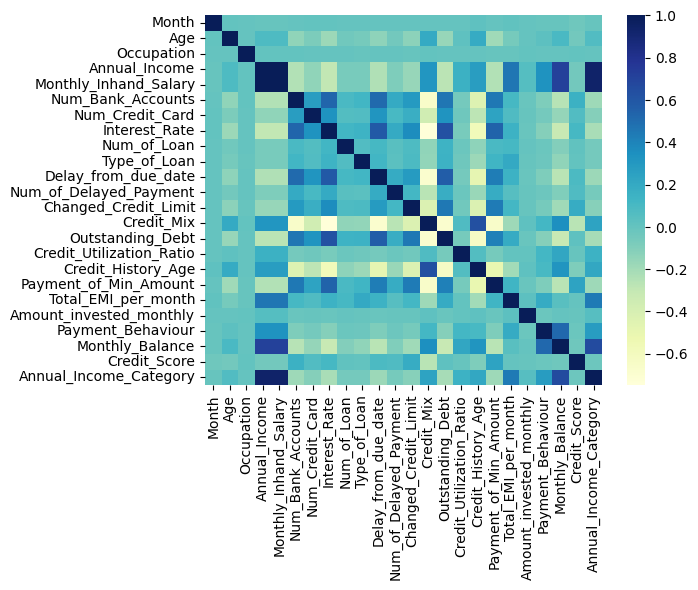

<Figure size 500x500 with 0 Axes>

In [268]:
#corrilation
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu")
plt.figure(figsize = (5,5))
plt.show()

* Strong correlations: Between 'Annual Income' and 'Monthly Inhand Salary', and between 'Credit Mix' and 'Credit History Age'.
* Low/Negative correlations: 'Type of Loan' and 'Outstanding Debt', and 'Payment of Minimum Amount' with 'Monthly Balance'.
* Clustered groups: Financial variables like 'EMI', 'Outstanding Debt', and 'Credit Utilization' are strongly related.

In [282]:

import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
import warnings
warnings.filterwarnings("ignore")


test_data=pd.read_csv('/kaggle/input/a-t-w/test.csv')


class DataPreprocessor:
    def __init__(self):
     pass

    def drop_columns(self,data, columns):
        data.drop(columns, axis='columns', inplace=True)
        return data
   
    def clean_age(self,data):
        data["Age"] = data["Age"].str.replace("-", "", regex=False).str.replace("_", "", regex=False)
        data["Age"] = pd.to_numeric(data["Age"], downcast='integer', errors="coerce")
        data["Age"] = data["Age"].apply(lambda x: np.nan if x > 100 else x)
        data["Age"] = data.groupby("Customer_ID")["Age"].transform(lambda x: x.fillna(x.median()))
        data['Age'] = pd.cut(data['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle_Aged', 'Senior'])
        return data

    def clean_occupation(self,data):
        data["Occupation"] = data["Occupation"].replace("_______", "")
        data["Occupation"] = data.groupby("Customer_ID")["Occupation"].transform(
            lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "unemployed"))
        return data

    def clean_annual_income(self,data):
        data["Annual_Income"] = data["Annual_Income"].str.replace("_", "", regex=False)
        data["Annual_Income"] = pd.to_numeric(data["Annual_Income"], errors="coerce")
        data['Annual_Income_Category'] = pd.cut(data['Annual_Income'], bins=[0, 50000, 100000, np.inf], labels=['Low', 'Medium', 'High'])
        return data

    def clean_monthly_inhand_salary(self,data):
        data["Monthly_Inhand_Salary"] = data.groupby("Customer_ID")["Monthly_Inhand_Salary"].transform(
            lambda x: x.fillna(x.median()))
        data["Monthly_Inhand_Salary"].fillna(data["Monthly_Inhand_Salary"].median(), inplace=True)
        return data

    def clean_num_of_loan(self,data):
        data["Num_of_Loan"] = data["Num_of_Loan"].str.replace("-", "", regex=False).str.replace("_", "", regex=False).str.replace("-100", "0", regex=False)
        data["Num_of_Loan"] = pd.to_numeric(data["Num_of_Loan"], downcast='integer', errors="coerce")
        return data

    def clean_type_of_loan(self,data):
        def process_cell(value):
            if pd.isna(value):
                return "Not Specified"
            elif "," in value:
                return "Other"
            else:
                return value.strip()

        data["Type_of_Loan"] = data["Type_of_Loan"].apply(process_cell)
        return data

    def clean_num_of_delayed_payment(self,data):
        data["Num_of_Delayed_Payment"] = data["Num_of_Delayed_Payment"].str.replace("_", "", regex=False)
        data["Num_of_Delayed_Payment"] = pd.to_numeric(data["Num_of_Delayed_Payment"], errors="coerce")
        data["Num_of_Delayed_Payment"] = data.groupby("Customer_ID")["Num_of_Delayed_Payment"].transform(lambda x: x.fillna(x.median()))
        data["Num_of_Delayed_Payment"].fillna(data["Num_of_Delayed_Payment"].median(), inplace=True)

        return data

    def clean_changed_credit_limit(self,data):
        data["Changed_Credit_Limit"] = data["Changed_Credit_Limit"].str.replace("_", "", regex=False)
        data["Changed_Credit_Limit"] = pd.to_numeric(data["Changed_Credit_Limit"], errors="coerce")
        data["Changed_Credit_Limit"] = data.groupby("Customer_ID")["Changed_Credit_Limit"].transform(lambda x: x.fillna(x.median()))
        return data

    def clean_credit_mix(self,data):
        data["Credit_Mix"] = data["Credit_Mix"].replace("_", np.nan)
        data["Credit_Mix"] = data.groupby("Customer_ID")["Credit_Mix"].transform(
            lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Standard"))
        return data

    def clean_outstanding_debt(self,data):
        data["Outstanding_Debt"] = data["Outstanding_Debt"].replace("_", "", regex=True)
        data["Outstanding_Debt"] = pd.to_numeric(data["Outstanding_Debt"], errors="coerce")
        return data

    def clean_credit_history_age(self,data):
        data["Credit_History_Age"] = data.groupby("Customer_ID")["Credit_History_Age"].transform(
            lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "0 Years and 0 Months"))

        def convert_to_months(age_str):
            match = re.match(r"(\d+)\sYears\sand\s(\d+)\sMonths", age_str)
            if match:
                years = int(match.group(1))
                months = int(match.group(2))
                return years * 12 + months
            return np.nan

        data["Credit_History_Age"] = data["Credit_History_Age"].apply(convert_to_months)
        return data

    def clean_payment_of_min_amount(self,data):
        data["Payment_of_Min_Amount"] = data["Payment_of_Min_Amount"].replace("NM", "No")
        return data

    def clean_amount_invested_monthly(self,data):
        data["Amount_invested_monthly"] = data["Amount_invested_monthly"].replace("__10000__", "1000")
        data["Amount_invested_monthly"] = pd.to_numeric(data["Amount_invested_monthly"], errors="coerce").round(3)
        data["Amount_invested_monthly"] = data.groupby("Customer_ID")["Amount_invested_monthly"].transform(lambda x: x.fillna(x.mean()))
        return data

    def clean_payment_behaviour(self,data):
        data["Payment_Behaviour"] = data["Payment_Behaviour"].replace("!@9#%8", np.nan)
        overall_mode = data["Payment_Behaviour"].mode()[0]
        data["Payment_Behaviour"] = data.groupby("Customer_ID")["Payment_Behaviour"].transform(
            lambda x: x.fillna(x.mode()[0] if not x.mode().empty else overall_mode))
        return data

    def clean_monthly_balance(self,data):
        data["Monthly_Balance"] = data["Monthly_Balance"].replace("__", "", regex=True)
        data["Monthly_Balance"] = pd.to_numeric(data["Monthly_Balance"], errors="coerce").round(3)
        data["Monthly_Balance"] = data.groupby("Customer_ID")["Monthly_Balance"].transform(lambda x: x.fillna(x.median()))
        data["Monthly_Balance"].fillna(data["Monthly_Balance"].median(), inplace=True)

        return data
    
    def remove_outliers_iqr(self, data, column):
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    def clip_values(self, data, column, lower_bound=None, upper_bound=None):
        data[column] = np.clip(data[column], lower_bound, upper_bound)



    def preprocess_data(self,data):
        data = self.clean_age(data)
        data = self.clean_occupation(data)
        data = self.clean_annual_income(data)
        data = self.clean_monthly_inhand_salary(data)
        data = self.clean_num_of_loan(data)
        data = self.clean_type_of_loan(data)
        data = self.clean_num_of_delayed_payment(data)
        data = self.clean_changed_credit_limit(data)
        data = self.clean_credit_mix(data)
        data = self.clean_outstanding_debt(data)
        data = self.clean_credit_history_age(data)
        data = self.clean_payment_of_min_amount(data)
        data = self.clean_amount_invested_monthly(data)
        data = self.clean_payment_behaviour(data)
        data = self.clean_monthly_balance(data)

        # Remove outliers
        data = self.remove_outliers_iqr(data, 'Annual_Income')
        data = self.remove_outliers_iqr(data, 'Interest_Rate')
        data = self.remove_outliers_iqr(data, 'Total_EMI_per_month')

        # Clip values
        self.clip_values(data, 'Num_Bank_Accounts', None, 15)
        self.clip_values(data, 'Num_Credit_Card', None, 20)
        self.clip_values(data, 'Num_of_Loan', None, 150)
        self.clip_values(data, 'Num_of_Delayed_Payment', None, 200)
        self.clip_values(data, 'Changed_Credit_Limit', None, 35)
        self.clip_values(data, 'Monthly_Balance', 0, None)

        columns_to_drop = ['Name', 'SSN', 'ID', 'Num_Credit_Inquiries','Customer_ID']
        self.drop_columns(data, columns_to_drop)
      
        return data



class DataEncoder:
    def __init__(self):
        self.cols_to_scale = [
            'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Credit_Card',
            'Interest_Rate', 'Outstanding_Debt', 'Credit_History_Age',
            'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance',
            'Delay_from_due_date', 'Num_of_Delayed_Payment','Credit_Utilization_Ratio'
        ]
        
        self.scaler = MinMaxScaler()

        self.encoders = {
            'Credit_Mix': [['Bad', 'Standard', 'Good']],
            'Age': [['Young', 'Middle_Aged', 'Senior']],
            'Annual_Income_Category': [['Low', 'Medium', 'High']],
            'Payment_Behaviour': [
                ['Low_spent_Small_value_payments', 'Low_spent_Medium_value_payments',
                 'Low_spent_Large_value_payments', 'High_spent_Small_value_payments',
                 'High_spent_Medium_value_payments', 'High_spent_Large_value_payments']
            ],
            'Month' :[[ 'January', 'February', 'March', 'April', 'May',
            'June', 'July', 'August','September', 'October','November', 'December']]
        }

        self.columns_to_encode = ['Type_of_Loan', 'Occupation', 'Payment_of_Min_Amount']

        self.label_encoder = LabelEncoder()

    def apply_min_max_scaling(self, data):
        data[self.cols_to_scale] = self.scaler.fit_transform(data[self.cols_to_scale])

    def apply_ordinal_encoding(self, data):
        for column, categories in self.encoders.items():
            encoder = OrdinalEncoder(categories=categories)
            data[column] = encoder.fit_transform(data[[column]])

    def apply_label_encoding(self, data):
        for column in self.columns_to_encode:
            data[column] = self.label_encoder.fit_transform(data[column])


    def preprocess(self, data):
        self.apply_min_max_scaling(data)
        self.apply_ordinal_encoding(data)
        self.apply_label_encoding(data)
        return data


preprocessor1 = DataPreprocessor()
test_data = preprocessor1.preprocess_data(test_data)


preprocessor2 = DataEncoder()
data = preprocessor2.preprocess(test_data)




# Train

In [272]:
# Define X and y 
X = data.drop(['Credit_Score'], axis=1.0)
Y = data['Credit_Score']

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Apply SMOTE to the training data to make Y balance 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [273]:
def train_evaluate_model(model, X_train, y_train, X_val, y_val):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Calculate evaluation metrics for validation
    evaluation = {
        'Model': model.__class__.__name__,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Validation Accuracy': accuracy_score(y_val, y_val_pred),
        'Precision': precision_score(y_val, y_val_pred, average='weighted'),
        'Recall': recall_score(y_val, y_val_pred, average='weighted'),
        'F1-Score': f1_score(y_val, y_val_pred, average='weighted')
    }
    return evaluation

In [302]:
rf_model = RandomForestClassifier(random_state=42,
    max_depth=30,  
    min_samples_split=5,  
    min_samples_leaf=2, 
    n_estimators=200, 
    max_features='sqrt',)

logreg_model = LogisticRegression(random_state=42,
    solver='lbfgs',  
    multi_class='multinomial', 
    max_iter=2000,  
    C=1.0,   )
                                  
xgb_model = xgb.XGBClassifier(  random_state=42,
    learning_rate=0.05,  
    max_depth=10,  
    n_estimators=300, 
    colsample_bytree=0.8,  
    subsample=0.8,  
    reg_alpha=1,
    reg_lambda=1,  )

                              
dtc_model = DecisionTreeClassifier( random_state=42,
    max_depth=15, 
    min_samples_split=20, 
    min_samples_leaf=10,  
    criterion='gini',  )

In [304]:
# Train and evaluate all models

rf_evaluation = train_evaluate_model(rf_model, X_train_resampled, y_train_resampled, X_val, y_val)
logreg_evaluation = train_evaluate_model(logreg_model, X_train_resampled, y_train_resampled, X_val, y_val)
xgb_evaluation = train_evaluate_model(xgb_model, X_train_resampled, y_train_resampled, X_val, y_val)
dtc_evaluation = train_evaluate_model(dtc_model, X_train_resampled, y_train_resampled, X_val, y_val)

RandomForestClassifier: Best performer with high training and validation accuracy, balanced precision, recall, and F1-score, making it the most reliable model.
XGBClassifier: Strong contender, with good precision, recall, and F1-score, though slightly behind the RandomForest in terms of validation accuracy.
LogisticRegression: Underperforms with lower accuracy, precision, recall, and F1-score, struggling to generalize well to the validation set.
DecisionTreeClassifier: Shows lower performance, particularly in terms of validation accuracy and recall, and could benefit from improvements like pruning.

Overall: RandomForestClassifier is the top choice, followed by XGBClassifier, while LogisticRegression and DecisionTreeClassifier perform weaker in this case.


## save the best model 

In [306]:
# save the model
with open('rf2_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

In [280]:
# load the model
with open('rf22_model.pkl', 'rb') as f:
    model2 = pickle.load(f)

In [283]:
# predict 
test_predictions = model2.predict(test_data) 

In [284]:
test_predictions

array([0, 0, 0, ..., 1, 1, 1])

### hyperparameters tuning and grid search

In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    evaluation = {
        'Model': model.__class__.__name__,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Validation Accuracy': accuracy_score(y_val, y_val_pred),
        'Precision': precision_score(y_val, y_val_pred, average='weighted'),
        'Recall': recall_score(y_val, y_val_pred, average='weighted'),
        'F1-Score': f1_score(y_val, y_val_pred, average='weighted')
    }
    return evaluation

In [ ]:
# Define parameter grids for each model
param_grids = {
    
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [5, 10, 20],
        'min_samples_leaf': [2, 5, 10],
        'max_features': ['sqrt', 'log2']
    },
    'LogisticRegression': {
        'solver': ['lbfgs', 'newton-cg', 'saga'],
        'multi_class': ['multinomial'],
        'C': [0.01, 0.1, 1, 10],
        'max_iter': [500, 1000, 2000]
    },
    'XGBClassifier': {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [6, 10, 15],
        'n_estimators': [100, 200, 300],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'subsample': [0.7, 0.8, 1.0],
        'reg_alpha': [0, 1, 10],
        'reg_lambda': [1, 10, 100]
    },
    'DecisionTree': {
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10],
        'criterion': ['gini', 'entropy']
    }
}

In [ ]:
# Define the models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'XGBClassifier': xgb.XGBClassifier(random_state=42, use_label_encoder=False),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

In [ ]:
best_estimators = {}
for model_name, model in models.items():
    print(f"Apply Grid Search for {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validated accuracy for {model_name}: {grid_search.best_score_}")


In [ ]:
# Evaluate the best models
evaluation_results = []
for model_name, best_model in best_estimators.items():
    print(f"Evaluating {model_name}...")
    eval_result = evaluate_model(best_model, X_train_resampled, y_train_resampled, X_val, y_val)
    evaluation_results.append(eval_result)

In [305]:
evaluation_results = [rf_evaluation, logreg_evaluation, xgb_evaluation,dtc_evaluation]
evaluation_df = pd.DataFrame(evaluation_results)
print(evaluation_df)

                    Model  Train Accuracy  Validation Accuracy  Precision  \
0  RandomForestClassifier        0.977888             0.806537   0.812391   
1      LogisticRegression        0.708889             0.651057   0.693489   
2           XGBClassifier        0.941550             0.799549   0.801186   
3  DecisionTreeClassifier        0.832844             0.730516   0.741404   

     Recall  F1-Score  
0  0.806537  0.807415  
1  0.651057  0.655547  
2  0.799549  0.800050  
3  0.730516  0.732755  
